Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [ ] Choose your target. Which column in your tabular dataset will you predict?
- [ ] Choose which observations you will use to train, validate, and test your model. And which observations, if any, to exclude.
- [ ] Determine whether your problem is regression or classification.
- [ ] Choose your evaluation metric.
- [ ] Begin to clean and explore your data.
- [ ] Begin to choose which features, if any, to exclude. Would some features "leak" information from the future?


In [2]:
data_path = '~/Documents/DS/Data/kic/'

In [3]:
# Import the libraries I'm going to need to explore and clean this data
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

In [135]:
# Read in the raw data to dataframe
table1 = pd.read_csv(data_path + 'exoTrain.csv')
table2 = pd.read_csv(data_path + 'exoTest.csv')

In [136]:
# Look at the shape of each dataframe
table1.shape, table2.shape

((5087, 3198), (570, 3198))

# Naive Baseline
> The naive baseline is used to confirm the accuracy of the majority class baseline.
> We can use this baseline to establish how we want to model the data, and which metric
> to use to gauge success.

> The "LABEL" column here is the vector indicating if an exo planet transit was **confirmed**.
> It does not confirm other types of transits (comet, asteroid, star, or other celestial objects).
> The naive baseline accuracy is 99%, so accuracy is **not** the best metric to use.

In [137]:
table1['LABEL'].value_counts(normalize=True)

1    0.992727
2    0.007273
Name: LABEL, dtype: float64

In [138]:
table2['LABEL'].value_counts(normalize=True)

1    0.991228
2    0.008772
Name: LABEL, dtype: float64

In [139]:
# Exploring the data
table1.describe()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
count,5087.000000,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,...,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5.087000e+03,5087.000000,5087.000000,5087.000000,5087.000000
mean,1.007273,1.445054e+02,1.285778e+02,1.471348e+02,1.561512e+02,1.561477e+02,1.469646e+02,1.168380e+02,1.144983e+02,1.228639e+02,...,3.485578e+02,4.956476e+02,6.711211e+02,7.468790e+02,6.937372e+02,6.553031e+02,-494.784966,-544.594264,-440.239100,-300.536399
std,0.084982,2.150669e+04,2.179717e+04,2.191309e+04,2.223366e+04,2.308448e+04,2.410567e+04,2.414109e+04,2.290691e+04,2.102681e+04,...,2.864786e+04,3.551876e+04,4.349963e+04,4.981375e+04,5.087103e+04,5.339979e+04,17844.469520,17722.339334,16273.406292,14459.795577
min,1.000000,-2.278563e+05,-3.154408e+05,-2.840018e+05,-2.340069e+05,-4.231956e+05,-5.975521e+05,-6.724046e+05,-5.790136e+05,-3.973882e+05,...,-3.240480e+05,-3.045540e+05,-2.933140e+05,-2.838420e+05,-3.288214e+05,-5.028894e+05,-775322.000000,-732006.000000,-700992.000000,-643170.000000
25%,1.000000,-4.234000e+01,-3.952000e+01,-3.850500e+01,-3.505000e+01,-3.195500e+01,-3.338000e+01,-2.813000e+01,-2.784000e+01,-2.683500e+01,...,-1.760000e+01,-1.948500e+01,-1.757000e+01,-2.076000e+01,-2.226000e+01,-2.440500e+01,-26.760000,-24.065000,-21.135000,-19.820000
50%,1.000000,-7.100000e-01,-8.900000e-01,-7.400000e-01,-4.000000e-01,-6.100000e-01,-1.030000e+00,-8.700000e-01,-6.600000e-01,-5.600000e-01,...,2.600000e+00,2.680000e+00,3.050000e+00,3.590000e+00,3.230000e+00,3.500000e+00,-0.680000,0.360000,0.900000,1.430000
75%,1.000000,4.825500e+01,4.428500e+01,4.232500e+01,3.976500e+01,3.975000e+01,3.514000e+01,3.406000e+01,3.170000e+01,3.045500e+01,...,2.211000e+01,2.235000e+01,2.639500e+01,2.909000e+01,2.780000e+01,3.085500e+01,18.175000,18.770000,19.465000,20.280000
max,2.000000,1.439240e+06,1.453319e+06,1.468429e+06,1.495750e+06,1.510937e+06,1.508152e+06,1.465743e+06,1.416827e+06,1.342888e+06,...,1.779338e+06,2.379227e+06,2.992070e+06,3.434973e+06,3.481220e+06,3.616292e+06,288607.500000,215972.000000,207590.000000,211302.000000


## Interpretation of first glance
This data is presented in a time-series format. Each column appears to be a measurement taken a certain point, or at a certain interval, of time. Thus, this data needs to be brought from it's current format into a format with discernable features. The best way to do this quickly might be to do a full band spectrum analysis.


In [145]:
# table1 is the training data, and table2 is the testing set.
# Seperate the target vector and feature matrix

y_train = table1['LABEL']
X_train = table1.drop(columns=['LABEL'])

y_test = table2['LABEL']
X_test = table2.drop(columns=['LABEL'])

In [146]:
# The luminosity values measured for different stars varies wildly.
# Define a function to normalize the data
def normalize(X):
    Y = (X - np.mean(X)) / (max(X) - min(X))
    return Y

In [147]:
X_train = X_train.apply(normalize, axis=1)
X_test = X_test.apply(normalize, axis=1)

In [117]:
X_train.head()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,0.053834,0.047391,0.006510,-0.023699,-0.031772,-0.086410,-0.093128,-0.068161,-0.057650,-0.109164,...,-0.056482,-0.071934,-0.071934,0.009738,0.024779,0.052993,0.018843,0.033024,-0.003127,-0.031759
1,-0.050411,-0.042317,-0.081922,-0.052351,-0.115212,-0.104794,-0.126816,-0.124861,-0.122681,-0.105708,...,0.006648,-0.039721,-0.039721,-0.027988,0.004116,0.013124,-0.006847,0.022260,0.037550,0.043849
2,0.243983,0.245509,0.235186,0.227365,0.208538,0.212981,0.212283,0.222467,0.199285,0.221536,...,-0.037161,0.002382,0.002382,-0.017715,-0.013523,-0.001456,-0.009299,-0.017259,-0.036384,-0.048782
3,0.518501,0.551177,0.480659,0.474051,0.504754,0.496863,0.511941,0.494687,0.496425,0.513506,...,0.016215,0.001435,0.001435,0.054324,0.038636,-0.012562,-0.006456,-0.019827,-0.019889,0.029163
4,-0.399904,-0.401872,-0.404199,-0.395473,-0.381734,-0.373293,-0.360070,-0.368986,-0.356861,-0.350022,...,-0.212262,-0.141752,-0.141752,-0.125499,-0.157156,-0.155246,-0.141038,-0.135528,-0.145458,-0.181590


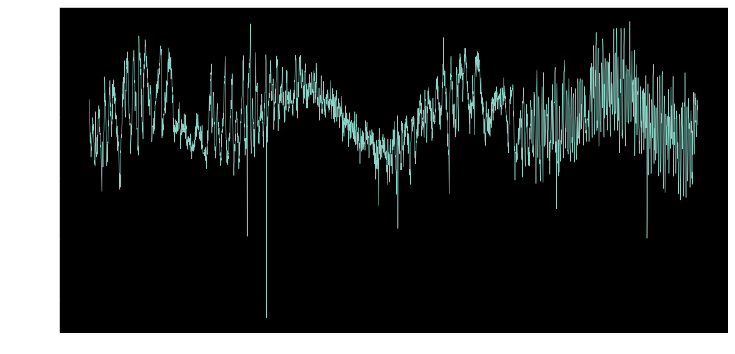

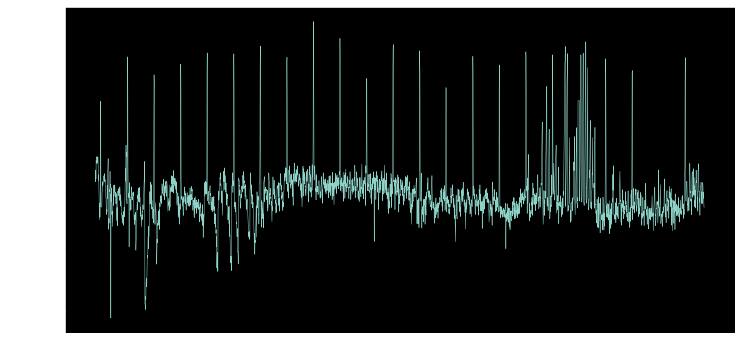

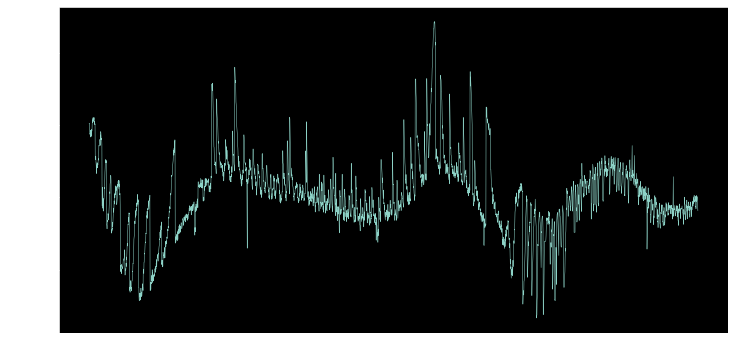

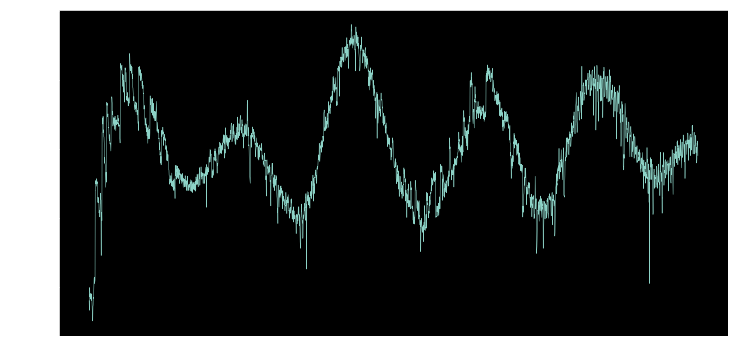

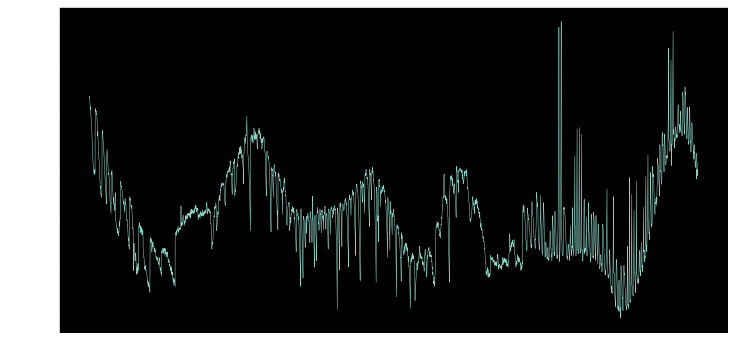

In [118]:
%matplotlib inline
for i in [0,1,2,3,4]:
    plt.figure(figsize=(12,6))
    plt.xticks([])
    plt.plot(X_normalized.iloc[i], color='C0', linewidth=0.5)
    plt.ylabel('Luminosity')
    plt.xlabel('Time --->')
    plt.show()

## Do a Fourier Transformation to do spectrum analysis
Create a power spectrum of this periodic data.


In [148]:
# Do Fourier Transformation to get the absolute value DFT. 
def transform(X):
    Y = sp.fft(X, n=X.size)
    return np.abs(Y)
X_train = X_train.apply(transform, axis=1)

In [153]:
X_train = pd.DataFrame.from_records(X_train)

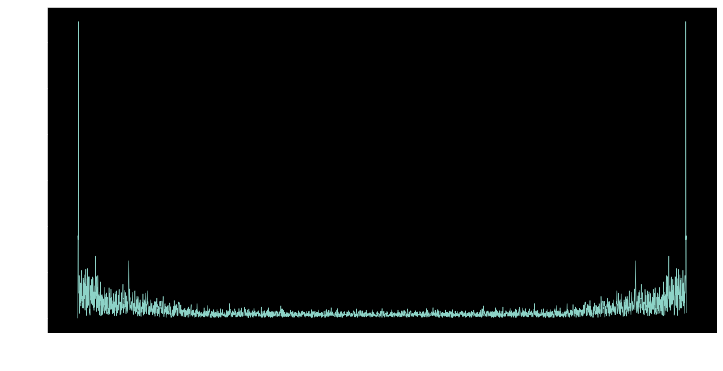

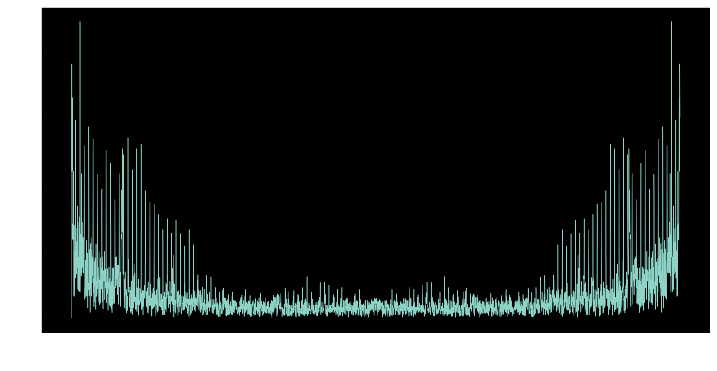

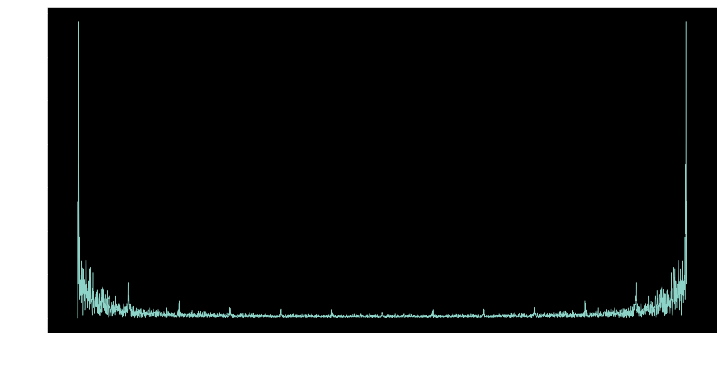

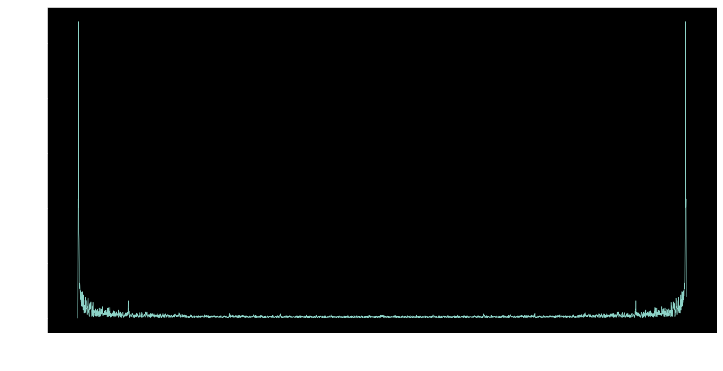

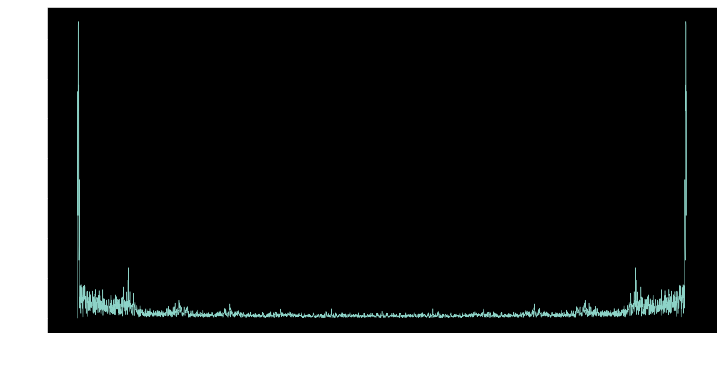

In [157]:
for i in [0,1,2,3,4]:
    plt.figure(figsize=(12,6))
    Y = X_train.iloc[i]
    X = np.arange(len(Y))*(1/(36.0*61.0)) 
    plt.ylabel('Fluctuation')
    plt.xlabel('Freq.')
    plt.plot(X, Y, color='C0', linewidth=0.5)
    plt.show()

## Thoughts on the data / metrics
1. This is a classification problem
2. This model does not require high accuracy (baseline acc would be 99%), instead requiring low FP, and perfect TP predictions
3. Leakage is not possible in this data
4. Only half of the spectrum is required because of symmetry. 